In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(199, 34716)
(199,)
[1 1 1 1 1]


In [60]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basis(nn.Module):
    def __init__(self, dim):
        super(Basis, self).__init__()
        self.A = nn.Parameter(torch.randn(dim,264,2).float().cuda())
        
    def compute(self, dim):
        A = self.A[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def to_img(self, dim):
        A = self.A[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        return A.detach().cpu().numpy()
    
    def scramble(self, dim):
        with torch.no_grad():
            self.A[dim] *= 0
            self.A[dim] += torch.randn(264,2).float().cuda()
    
xtr = torch.from_numpy(x).float().cuda()

# mu = torch.mean(xtr, axis=1, keepdims=True)
# xtr = xtr - mu
    
w = nn.Parameter(torch.randn(1,xtr.shape[0]).float().cuda())
u = nn.Parameter(torch.randn(1).float().cuda())
    
basis = Basis(3)
optim = torch.optim.Adam(basis.parameters(), lr=1e-1, weight_decay=0)

nepochs = 200
pperiod = 10
eye = torch.eye(1).float().cuda()

def rmse(a,b):
    return torch.mean((a-b)**2)**0.5

for n in range(basis.A.shape[0]):
    tgt = xtr
    cur = None
    print(f'Cur residual')
    with torch.no_grad():
        for m in range(n):
            A = basis.compute(m)
            A = A.unsqueeze(1).detach()
            w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-1*eye, A.T@tgt.T)
            xhat = (A@w).T
            tgt = tgt - xhat
            cur = cur + xhat if cur is not None else xhat
            print(float(rmse(cur, xtr)))
        print(f'Fitting {n}')
    if n > 0:
        start_loss = float(rmse(cur, xtr))
    for epoch in range(nepochs):
        optim.zero_grad()
        A = basis.compute(n)
        A = A.unsqueeze(1)
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-1*eye, A.T@tgt.T)
        xhat = (A@w).T
        rloss = rmse(tgt, xhat)
        rloss.backward()
        optim.step()
        if epoch == 0 and n == 0:
            start_loss = float(rloss)
        if epoch % 50 == 49 and float(rloss)/start_loss > 0.9995:
            print('Scrambling')
            basis.scramble(n)
        if epoch % pperiod == 0 or epoch == nepochs:
            print(f'{epoch} {float(rloss)}')
        
print('Complete')

Cur residual
Fitting 0
0 0.3004150986671448
10 0.2664659023284912
20 0.2173176109790802
30 0.2102314531803131
40 0.2083752155303955
50 0.20636241137981415
60 0.20475570857524872
70 0.20411260426044464
80 0.20386146008968353
90 0.20378480851650238
100 0.20374774932861328
110 0.2037302553653717
120 0.20372332632541656
130 0.2037203162908554
140 0.20371927320957184
150 0.203718900680542
160 0.20371876657009125
170 0.20371873676776886
180 0.20371873676776886
190 0.20371870696544647
Cur residual
0.20371873676776886
Fitting 1
0 0.20371705293655396
10 0.20164068043231964
20 0.1994408220052719
30 0.1973666250705719
40 0.1969890594482422
50 0.19686824083328247
60 0.19682539999485016
70 0.19681069254875183
80 0.19680635631084442
90 0.19680538773536682
100 0.19680491089820862
110 0.1968047022819519
120 0.19680458307266235
130 0.1968044638633728
140 0.19680437445640564
150 0.19680429995059967
160 0.1968042403459549
170 0.19680416584014893
180 0.19680410623550415
190 0.19680404663085938
Cur residua

In [71]:
ws = []
n = 3

with torch.no_grad():
    tgt = xtr
    cur = None
    for m in range(n):
        A = basis.compute(m)
        A = A.unsqueeze(1).detach()
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-1*eye, A.T@tgt.T)
        xhat = (A@w).T
        tgt = tgt - xhat
        cur = cur + xhat if cur is not None else xhat
        print(float(rmse(cur, xtr)))
        ws.append(w.squeeze().detach().cpu())
    print(f'Fitting {n}')
    
ws = torch.stack(ws)
idcs = np.where(0.5 > torch.abs(ws[1])/torch.abs(ws[2]))[0]
print(len(idcs))

0.20371870696544647
0.1968039572238922
0.19213221967220306
Fitting 3
25


In [64]:
ws[0][idcs]

tensor([14.0166, 30.1509, 25.0799, 24.7694, 24.5026, 25.1618, 42.6381, 51.0101,
        29.3025, 25.9578, 35.8311, 34.1757, 33.2473, 35.3820, 35.8523, 45.7241,
        30.1251, 26.5525, 27.3400, 36.9835, 32.6840, 28.7509, 50.9158, 40.3091,
        25.0568, 34.5180, 25.9994, 57.4506, 30.6458, 14.9023, 51.2621, 33.6244,
        57.3855, 44.4098, 35.6807, 42.4615, 43.5742, 34.2249, 29.3429, 53.3191,
        37.7938, 27.1013, 28.8858, 55.3073, 39.0197, 32.5569, 35.6337, 31.8389,
        33.4531, 35.6970, 41.2982, 19.6590, 20.6421, 26.9024, 42.6410, 25.3176,
        23.6501, 43.4886, 29.4539, 19.1706, 46.3231, 31.6842, 19.7260, 31.0106,
        26.6199, 47.6943, 33.9650])

In [72]:
ws[1][idcs]

tensor([5.4359, 6.1507, 6.2495, 5.0596, 5.3171, 6.7407, 9.0552, 9.4758, 4.2770,
        6.3940, 5.0273, 9.7357, 8.8779, 5.7602, 4.4853, 7.0519, 7.1008, 6.5350,
        7.7262, 8.1020, 6.1522, 6.0928, 5.7716, 5.6984, 6.3778])

In [73]:
ws[2][idcs]

tensor([13.3726, 13.6122, 13.8924, 22.5363, 20.4071, 22.4159, 18.8221, 20.3319,
        14.0632, 13.1366, 19.7542, 23.1050, 22.1050, 12.9663, 22.8218, 15.9366,
        22.1382, 19.6982, 24.7506, 20.5748, 23.5490, 16.2437, 12.4657, 20.3370,
        14.9944])

In [24]:
with torch.no_grad():
    a = torch.sum(torch.abs(basis.compute(0)*ws[0,57]))
    
print(a)

tensor(3174.4600, device='cuda:0')


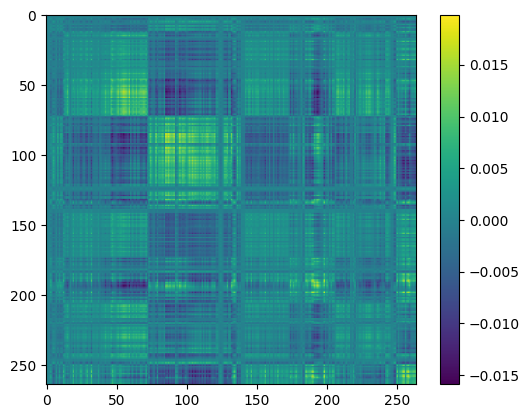

In [78]:
import matplotlib.pyplot as plt

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

plt.imshow(basis.to_img(2))
plt.colorbar()
plt.show()